In [48]:
# Project: Factors influencing whether tech employees seek mental health treatment

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, ttest_ind

# ------------------------
# Load the data
# ------------------------
df = pd.read_csv("/content/survey.csv")

# Basic overview
print("Dataset shape:", df.shape)
df.info()
print(df.head())
print(df.tail())
print(df.describe(include='all').T)
print(df.isnull().sum())
print("Duplicate rows:", df.duplicated().sum())

# ------------------------
# Clean Gender column
# ------------------------
def clean_gender(gender):
    if not isinstance(gender, str):
        return np.nan
    gender = gender.strip().lower()

    male_terms = ["male", "m", "man", "cis male", "cis man", "male (cis)",
                  "mal", "msle", "malr", "maile", "mail", "make"]
    female_terms = ["female", "f", "woman", "cis female", "cis-female/femme",
                    "female (cis)", "femake", "femail"]

    if gender in male_terms:
        return "Male"
    elif gender in female_terms:
        return "Female"
    else:
        return "Other/Non-binary"

df["Gender_Clean"] = df["Gender"].apply(clean_gender)
print(df["Gender_Clean"].value_counts())

# ------------------------
# Fill missing values for some columns
# ------------------------
df['self_employed'] = df['self_employed'].fillna("Unknown")
df['work_interfere'] = df['work_interfere'].fillna("Unknown")

work_cols = [
    "benefits", "care_options", "wellness_program", "seek_help",
    "anonymity", "leave", "mental_health_consequence",
    "phys_health_consequence", "coworkers", "supervisor",
    "mental_health_interview", "phys_health_interview",
    "mental_vs_physical", "obs_consequence"
]

# Standardize categorical values
mapping = {
    "yes": "Yes",
    "no": "No",
    "don't know": "Unknown",
    "not sure": "Unknown",
    "nan": "Unknown"
}

for col in work_cols:
    df[col] = df[col].astype(str).str.strip().str.lower().map(lambda x: mapping.get(x, x.title()))

# ------------------------
# Create Age Groups
# ------------------------
df['Age_Group'] = pd.cut(df['Age'], bins=[18,29,39,49,59,69,80],
                         labels=['18-29','30-39','40-49','50-59','60-69','70-80'])

Dataset shape: (1259, 27)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Timestamp                  1259 non-null   object
 1   Age                        1259 non-null   int64 
 2   Gender                     1259 non-null   object
 3   Country                    1259 non-null   object
 4   state                      744 non-null    object
 5   self_employed              1241 non-null   object
 6   family_history             1259 non-null   object
 7   treatment                  1259 non-null   object
 8   work_interfere             995 non-null    object
 9   no_employees               1259 non-null   object
 10  remote_work                1259 non-null   object
 11  tech_company               1259 non-null   object
 12  benefits                   1259 non-null   object
 13  care_options               1259 non-n

# **EDA**


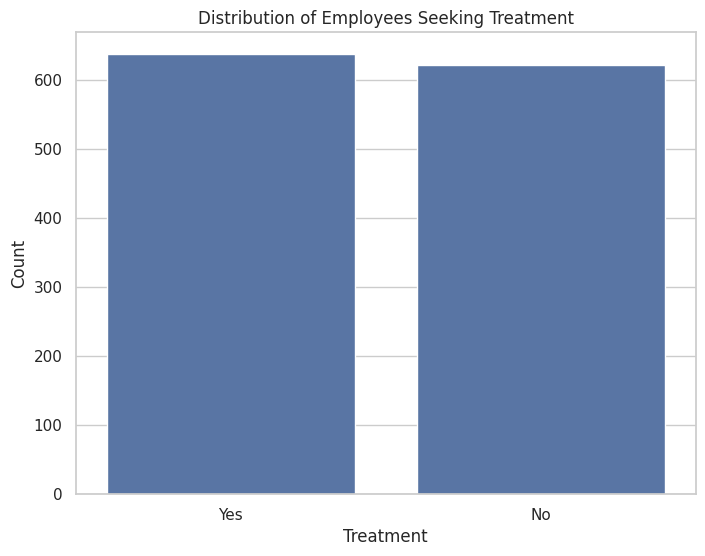

In [49]:
sns.set(style="whitegrid")

# Treatment distribution
plt.figure(figsize=(8,6))
sns.countplot(x='treatment', data=df)
plt.title('Distribution of Employees Seeking Treatment')
plt.xlabel('Treatment')
plt.ylabel('Count')
plt.show()


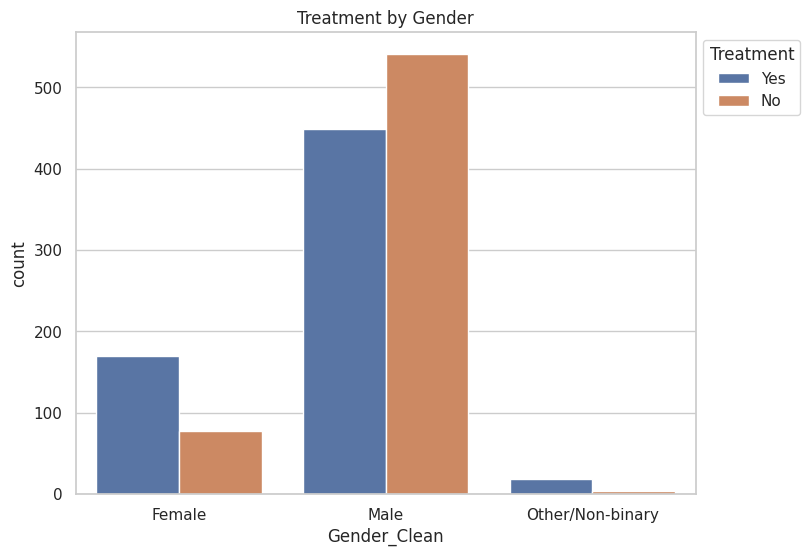

In [50]:
# Visualizing treatment distribution by gender
plt.figure(figsize=(8,6))
sns.countplot(data=df, x='Gender_Clean', hue='treatment')
plt.title('Treatment by Gender')
plt.legend(title='Treatment', loc='upper left', bbox_to_anchor=(1,1))
plt.show()

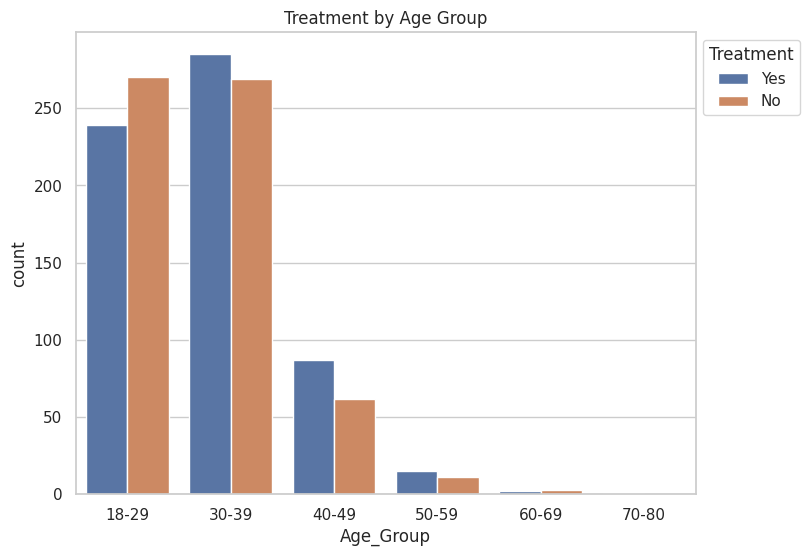

In [51]:
# Treatment by Age Group
plt.figure(figsize=(8,6))
sns.countplot(data=df, x='Age_Group', hue='treatment')
plt.title('Treatment by Age Group')
plt.legend(title='Treatment', loc='upper left', bbox_to_anchor=(1,1))
plt.show()



Crosstab: self_employed vs treatment
treatment            No       Yes
self_employed                    
No             0.497717  0.502283
Unknown        0.500000  0.500000
Yes            0.465753  0.534247


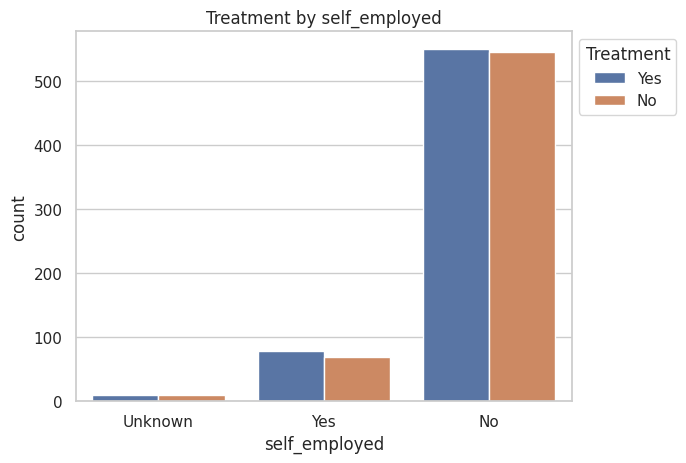


Crosstab: work_interfere vs treatment
treatment             No       Yes
work_interfere                    
Never           0.859155  0.140845
Often           0.145833  0.854167
Rarely          0.294798  0.705202
Sometimes       0.230108  0.769892
Unknown         0.984848  0.015152


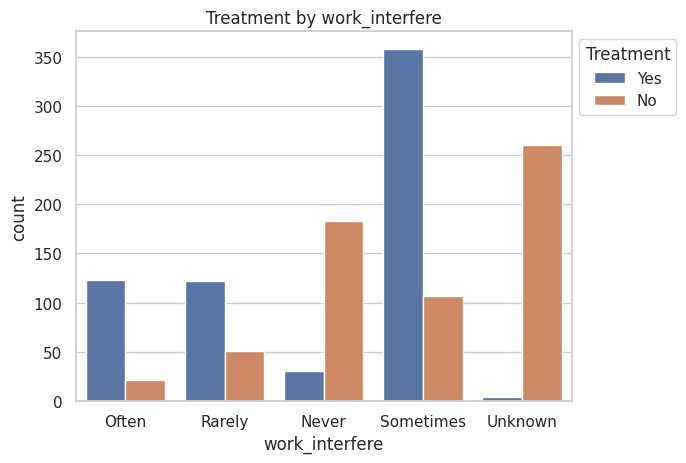


Crosstab: care_options vs treatment
treatment           No       Yes
care_options                    
No            0.586826  0.413174
Unknown       0.608280  0.391720
Yes           0.308559  0.691441


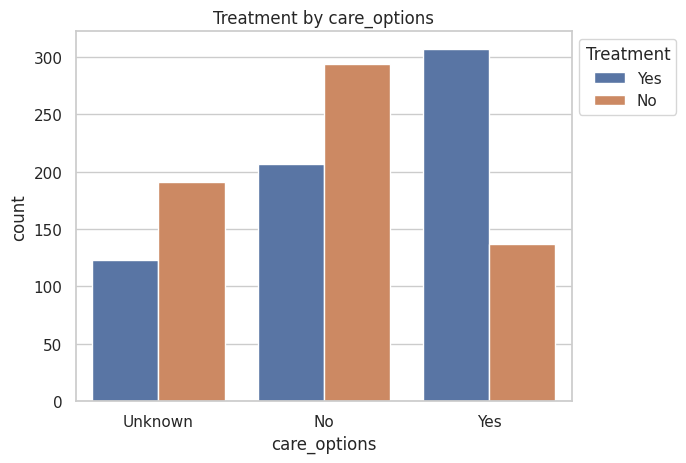


Crosstab: wellness_program vs treatment
treatment               No       Yes
wellness_program                    
No                0.501188  0.498812
Unknown           0.569149  0.430851
Yes               0.406114  0.593886


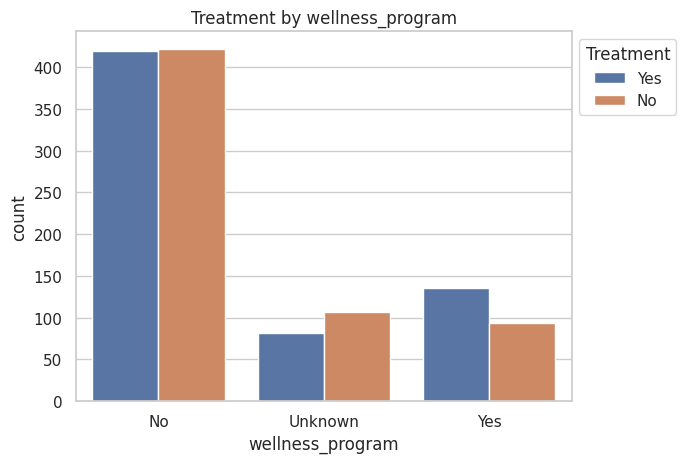


Crosstab: mental_health_consequence vs treatment
treatment                        No       Yes
mental_health_consequence                    
Maybe                      0.469602  0.530398
No                         0.571429  0.428571
Yes                        0.404110  0.595890


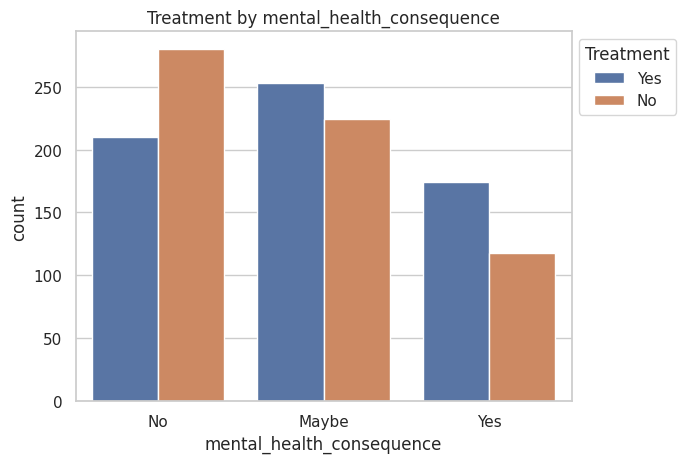


Crosstab: mental_health_interview vs treatment
treatment                      No       Yes
mental_health_interview                    
Maybe                    0.603865  0.396135
No                       0.475198  0.524802
Yes                      0.409091  0.590909


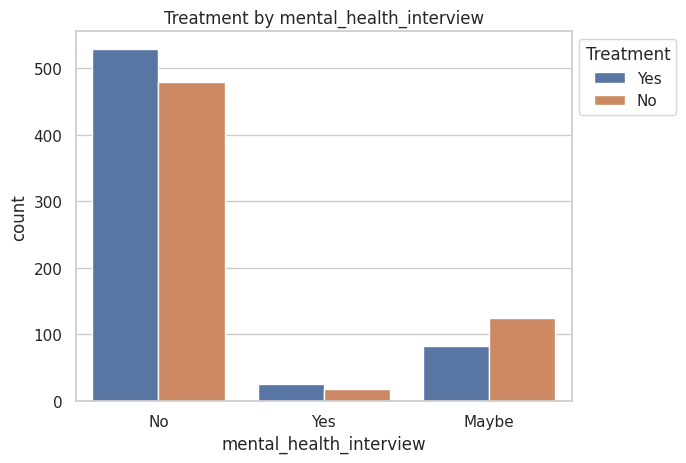


Crosstab: mental_vs_physical vs treatment
treatment                 No       Yes
mental_vs_physical                    
No                  0.405882  0.594118
Unknown             0.548611  0.451389
Yes                 0.489796  0.510204


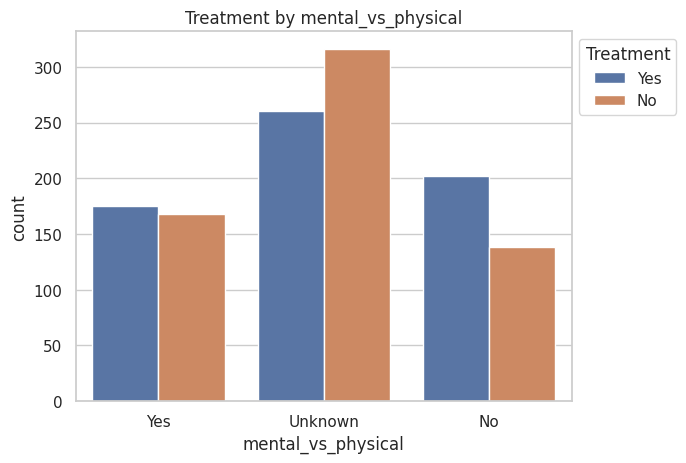

In [52]:
# Automatically select all columns related to workplace factors
work_cols = [col for col in df.columns if 'care' in col or 'wellness' in col or 'mental' in col]
categorical_cols = ['self_employed', 'work_interfere'] + work_cols

for col in categorical_cols:
    print(f"\nCrosstab: {col} vs treatment")
    print(pd.crosstab(df[col], df['treatment'], normalize='index'))

    sns.countplot(data=df, x=col, hue='treatment')
    plt.title(f'Treatment by {col}')
    plt.legend(title='Treatment', loc='upper left', bbox_to_anchor=(1,1))
    plt.show()

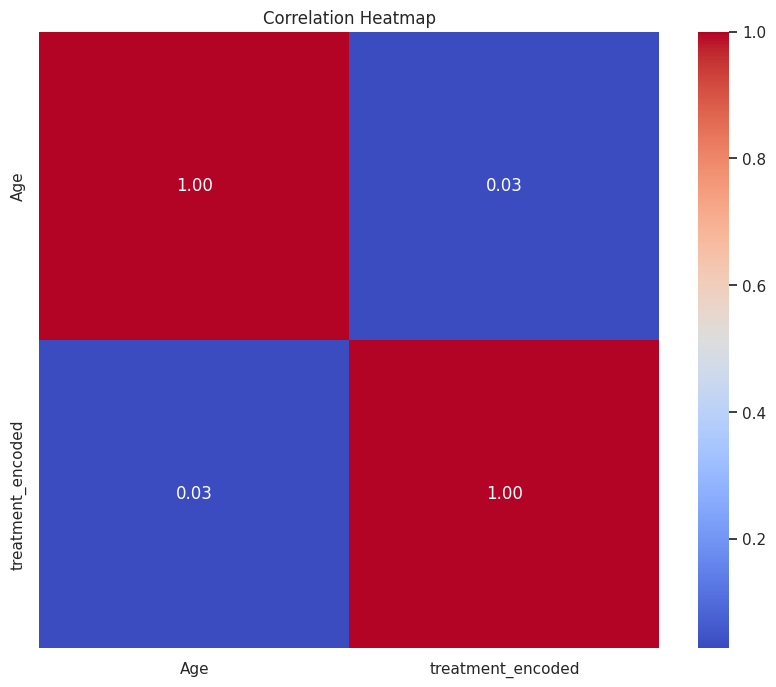

In [53]:
# Correlation Heatmap

df['treatment_encoded'] = df['treatment'].map({'Yes':1, 'No':0})
numeric_cols = df.select_dtypes(include=['number'])
corr_matrix = numeric_cols.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [54]:
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
# split age by treatment group
age_treat = df[df['treatment_encoded']==1]['Age']
age_no_treat = df[df['treatment_encoded']==0]['Age']

# Run T-test
t_statistic, p_value = ttest_ind(age_treat, age_no_treat)
print(f"T-statistic: {t_statistic:.3f}")
print(f"P-value: {p_value:.3f}")

T-statistic: 0.988
P-value: 0.323


In [55]:
# Automatically select all categorical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
# exculde treatement
categorical_cols = [col for col in categorical_cols if col != 'treatment_encoded']
# Run Chi-square tests for each categorical column
for col in categorical_cols:
    contingency = pd.crosstab(df[col], df['treatment_encoded'])
    chi2, p, dof, expected = chi2_contingency(contingency)
    print(f"\nChi-square test for {col.replace('_',' ').title()}: Chi2 = {chi2:.2f}, p = {p:.3f}")


Chi-square test for Timestamp: Chi2 = 1251.00, p = 0.447

Chi-square test for Gender: Chi2 = 90.13, p = 0.000

Chi-square test for Country: Chi2 = 69.80, p = 0.017

Chi-square test for State: Chi2 = 51.48, p = 0.204

Chi-square test for Self Employed: Chi2 = 0.53, p = 0.768

Chi-square test for Family History: Chi2 = 178.27, p = 0.000

Chi-square test for Treatment: Chi2 = 1255.00, p = 0.000

Chi-square test for Work Interfere: Chi2 = 594.92, p = 0.000

Chi-square test for No Employees: Chi2 = 8.76, p = 0.119

Chi-square test for Remote Work: Chi2 = 0.80, p = 0.371

Chi-square test for Tech Company: Chi2 = 1.09, p = 0.296

Chi-square test for Benefits: Chi2 = 64.84, p = 0.000

Chi-square test for Care Options: Chi2 = 94.76, p = 0.000

Chi-square test for Wellness Program: Chi2 = 11.50, p = 0.003

Chi-square test for Seek Help: Chi2 = 10.93, p = 0.004

Chi-square test for Anonymity: Chi2 = 26.42, p = 0.000

Chi-square test for Leave: Chi2 = 29.94, p = 0.000

Chi-square test for Mental 

In [56]:
# Summary Tables

def treatment_summary(col):
    summary = pd.crosstab(df[col], df['treatment'], normalize='index') * 100
    summary = summary.round(1)
    return summary[['Yes','No']]

print("\nTreatment by Gender (%):")
print(treatment_summary('Gender_Clean'))

print("\nTreatment by Age Group (%):")
print(treatment_summary('Age_Group'))


Treatment by Gender (%):
treatment          Yes    No
Gender_Clean                
Female            68.8  31.2
Male              45.4  54.6
Other/Non-binary  81.8  18.2

Treatment by Age Group (%):
treatment    Yes    No
Age_Group             
18-29       47.0  53.0
30-39       51.4  48.6
40-49       58.4  41.6
50-59       57.7  42.3
60-69       40.0  60.0
70-80      100.0   0.0
